In [1]:
import os
import sys
import json
import pickle
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.append("code/preprocessing/utils/")
from segment2D     import *
from segment3D     import *
from file_handling import *

sys.path.append("code/preprocessing/src/")
from ImUtils import commonStackReader

In [4]:
# Load segmented mask
mask = commonStackReader("250904.114139.MDCK-li.001.Group2.B1.T001P01_HT3D_26_mask.tiff")
dims = np.shape(mask)

# sum along z to get height
sum_mask = np.sum(mask, axis=0)

# compute reference value for cell bottom
z0_ref   = estimate_cell_bottom_reference(mask)

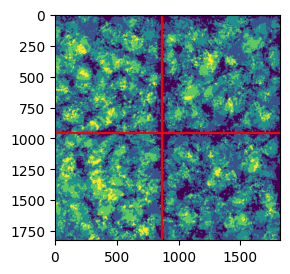

In [10]:
# since tiles are not identical, I identify borders between them here.
# these are hard-coded into split_tiles function

xmiddle =int(dims[2]/2)
ymiddle = int(dims[1]/2)

im00 = mask[z0_ref-1, :ymiddle, :xmiddle]
im01 = mask[z0_ref-1, :ymiddle, xmiddle:]
im10 = mask[z0_ref-1, ymiddle:, :xmiddle]
im11 = mask[z0_ref-1, ymiddle:, xmiddle:]

mean = im00 + im01 + im10 + im11
full_tile_size = 958

# position of tile edges
xy_edges = np.array([0, dims[1] / 2 - full_tile_size, dims[1] / 2, dims[1] / 2 + full_tile_size, dims[1]], dtype=int)


plt.subplot(121)
plt.imshow(im00[::-1] + im10 + im01.T + im11[::-1].T)
plt.axhline(full_tile_size, c='r')
plt.axvline(ymiddle - full_tile_size, c='r')

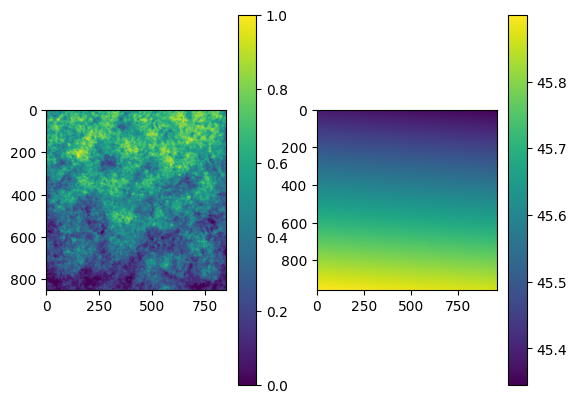

In [ ]:
# splitting stack in tiles
tiles = split_tiles(mask) 

tile_dims    = np.shape(tiles)
mean_tile_z0 = np.zeros([tile_dims[3], tile_dims[4]])
weight_tile  = np.zeros([tile_dims[0], tile_dims[1]])

# computing mean tile for fitting plane to cell bottom and weights to scale adjustment with amount of data below z0_ref
for iy in range(4):
    for ix in range(4):
        mean_tile_z0 += tiles[iy, ix, z0_ref-1] / 16
        weight_tile[iy, ix] = np.sum(tiles[iy, ix, z0_ref-2:z0_ref]) / (tile_dims[3] * tile_dims[4])


z0_plane = fit_plane(mean_tile_z0, [958, 958])

plt.subplot(121)
plt.imshow(mean_tile_z0)
plt.colorbar()

plt.subplot(122)
plt.imshow((z0_ref-z0_plane * weight_tile[0,3]))
plt.colorbar()

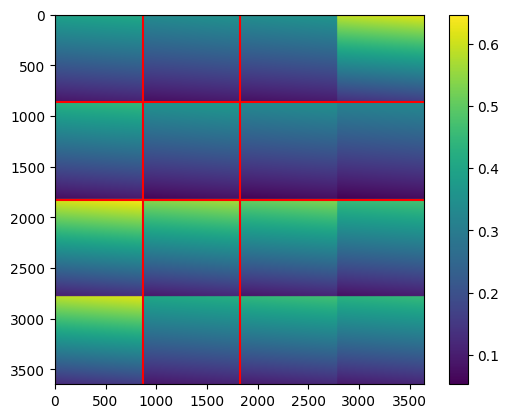

In [11]:
# combine z0_plane of each tile to one image
z0_image = combine_tiles(z0_plane, weight_tile)

plt.imshow(z0_image)
plt.axhline(xy_edges[0], c='r')
plt.axhline(xy_edges[1], c='r')
plt.axhline(xy_edges[2], c='r')

# plt.axhline(xy_edges[0]+46, c='b')
# # plt.axhline(xy_edges[1], c='b')
# plt.axhline(xy_edges[2]-46, c='b')

plt.axvline(xy_edges[0], c='r')
plt.axvline(xy_edges[1], c='r')
plt.axvline(xy_edges[2], c='r')

plt.colorbar()

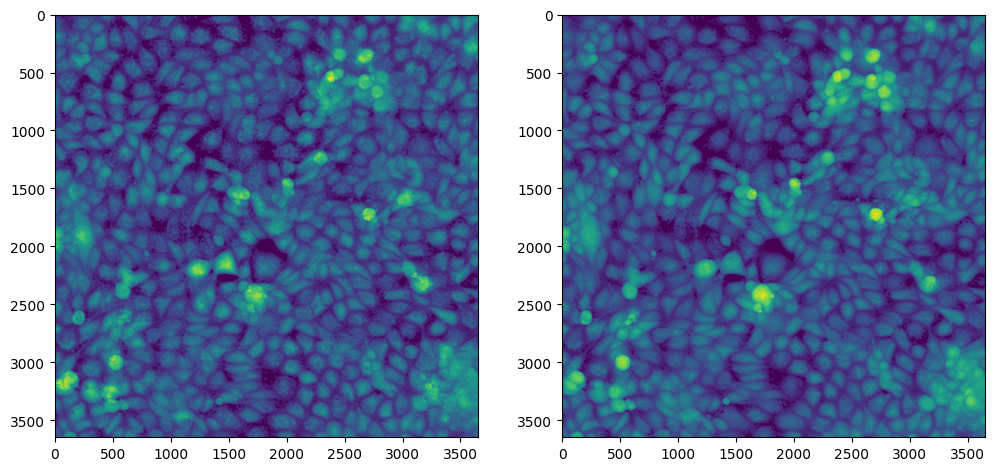

In [12]:
# plotting final mask
new_mask = update_cell_mask(mask, z0_ref, z0_image)
sum_new_mask = np.sum(new_mask, axis=0)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(sum_mask)

plt.subplot(122)
plt.imshow(sum_new_mask)

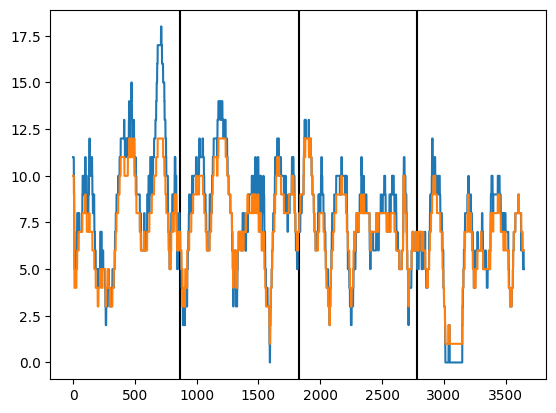

In [33]:
for i in range(1,4):
    plt.axvline(xy_edges[i], c="k")

i = 2820
plt.plot(sum_mask[i])
plt.plot(sum_new_mask[i])

(array([   0,  866, 1824, 2782, 3648]), 958)